In [56]:
"""
Trust Rank Implemmentation of Payments Dataset

Bhende Adarsh Suresh  - CS21BTECH11008
S Jagadeesh           - ES21BTECH11026
Subiksha Gayathiri KK - ES21BTECH11031
Aabisheg T            - ES21BTECH11001
Ranveer Sahu          - ES21BTECH11025
"""

import numpy as np
import pandas as pd

#Function to read and preprocess data
def read_data(payment_file, bad_sender_file):
    payment_data = pd.read_csv(payment_file)
    bad_senders = pd.read_csv(bad_sender_file)
    payment_data = payment_data.values
    bad_senders = bad_senders.values.flatten()
    
    return payment_data, bad_senders

#Transition matrix T
def create_transition_matrix(payment_data):
    unique_senders = np.unique(payment_data[:, 0])
    unique_receivers = np.unique(payment_data[:, 1])
    num_pages = max(np.max(unique_senders), np.max(unique_receivers))
    
    T = np.zeros((num_pages, num_pages))
    
    for sender, receiver, _ in payment_data:
        T[sender-1, receiver-1] += 1 / np.sum(payment_data[:, 1] == receiver)
    
    return T

# Inverse Matrix
def create_inverse_transition_matrix(T):
    sum_outlinks = np.sum(T, axis=1)
    U = np.zeros_like(T)
    for i in range(len(sum_outlinks)):
        if sum_outlinks[i] != 0: 
            U[:, i] = T[:, i] / sum_outlinks[i]
    
    return U

# PageRank 
def pagerank(T, alpha=0.85, max_iter=100, tol=1e-6):
    N = T.shape[0]
    r = np.ones(N) / N
    prev_r = np.zeros(N) # initializing the ranks 0 to all
    
    for _ in range(max_iter):
        prev_r[:] = r
        r = alpha * np.dot(T, r) + (1 - alpha) / N
        if np.linalg.norm(r - prev_r) < tol:
            break
    r /= np.sum(r) #Normalization
    return r


# TrustRank algorithm (Biased Page rank)
def trustrank(T, U, oracle_scores, alpha=0.85, max_iter=100, tol=1e-6):
    N = T.shape[0]
    r = np.ones(N) / N
    prev_r = np.zeros(N)
    
    for _ in range(max_iter):
        prev_r[:] = r
        r = alpha * np.dot(T, r) + (1 - alpha) * np.dot(U, oracle_scores)
        if np.linalg.norm(r - prev_r) < tol:
            break
    r /= np.sum(r)  #Normalization
    
    return r
# calling data manipulation function
payment_data, bad_senders = read_data('Payments.csv', 'bad_sender.csv')
T = create_transition_matrix(payment_data)
U = create_inverse_transition_matrix(T)
page_rank_scores = pagerank(T)
print("PageRank scores:", page_rank_scores)

#calling trustrank function
oracle_scores = np.ones(len(T))
for bad_sender in bad_senders:
    oracle_scores[bad_sender - 1] = 0
trust_scores = trustrank(T, U, oracle_scores)
print("TrustRank scores:", trust_scores)



PageRank scores: [0.00036039 0.00036039 0.00036039 ... 0.00040179 0.00094892 0.00127095]
TrustRank scores: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.58449893e-05
 2.84592716e-03 5.26740742e-03]


In [57]:
#Fuction to get the top n scores
def print_top_bottom_scores(scores, n=10):
    sorted_indices = np.argsort(scores)
    
    top_n_scores = scores[sorted_indices[-n:]][::-1]
    top_n_indices = sorted_indices[-n:][::-1]
    bottom_n_scores = scores[sorted_indices[:n]]
    bottom_n_indices = sorted_indices[:n]
    
    print("Top {} Scores:".format(n))
    for i in range(n):
        print("Node: {}, Score: {}".format(top_n_indices[i], top_n_scores[i]))
    
    print("\nBottom {} Scores:".format(n))
    for i in range(n):
        print("Node: {}, Score: {}".format(bottom_n_indices[i], bottom_n_scores[i]))
print_top_bottom_scores(trust_scores, n=10)


Top 10 Scores:
Node: 1355, Score: 0.05108516310915958
Node: 1033, Score: 0.03463192849591599
Node: 1038, Score: 0.030652845174689067
Node: 1395, Score: 0.030502529200101002
Node: 1308, Score: 0.02773914393449063
Node: 1097, Score: 0.027723055403660792
Node: 1107, Score: 0.02270375678655434
Node: 1089, Score: 0.02088107184333535
Node: 1088, Score: 0.01942627592072498
Node: 1074, Score: 0.018924541144203444

Bottom 10 Scores:
Node: 0, Score: 0.0
Node: 1152, Score: 0.0
Node: 1149, Score: 0.0
Node: 1130, Score: 0.0
Node: 1126, Score: 0.0
Node: 1124, Score: 0.0
Node: 1118, Score: 0.0
Node: 1117, Score: 0.0
Node: 1116, Score: 0.0
Node: 1114, Score: 0.0


In [58]:
def print_top_scores(scores, top_n=799,filename="results.txt"):
   sorted_indices = np.argsort(scores)[::-1]  # Sort indices in descending order
   with open(filename, "w") as file:
        # file.write("Top {} scores:\n".format(top_n))
        for i in range(min(top_n, len(scores))):
            file.write("Node {}: Score = {}\n".format(sorted_indices[i] + 1, scores[sorted_indices[i]]))

In [59]:
print_top_scores(trust_scores)

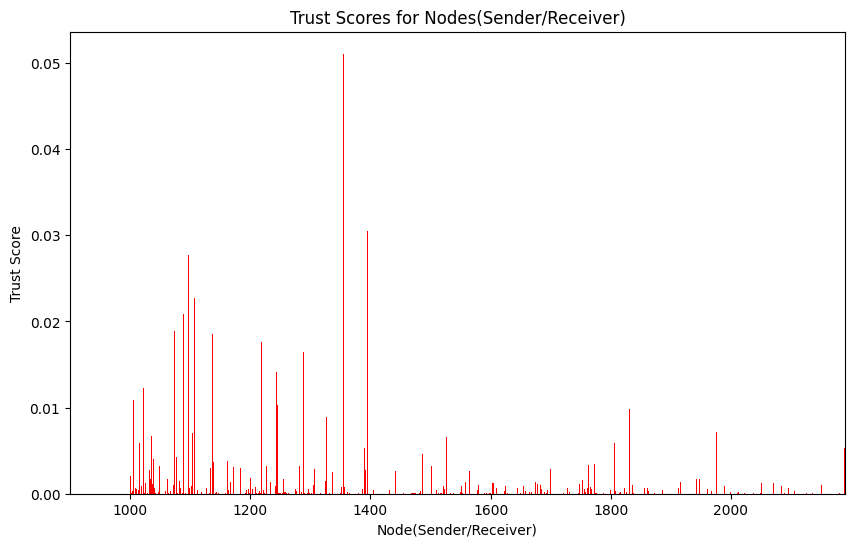

In [60]:
import matplotlib.pyplot as plt
def plot_score_distribution(trust_scores, filename="score_distribution.png"):
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(trust_scores)), trust_scores,color='red')
    plt.xlabel('Node(Sender/Receiver)')
    plt.ylabel('Trust Score')
    plt.title('Trust Scores for Nodes(Sender/Receiver)')
    
    # Set x-axis limits starting from 800
    plt.xlim(900, len(trust_scores))
    
    plt.savefig(filename)
    plt.show()
plot_score_distribution(trust_scores)

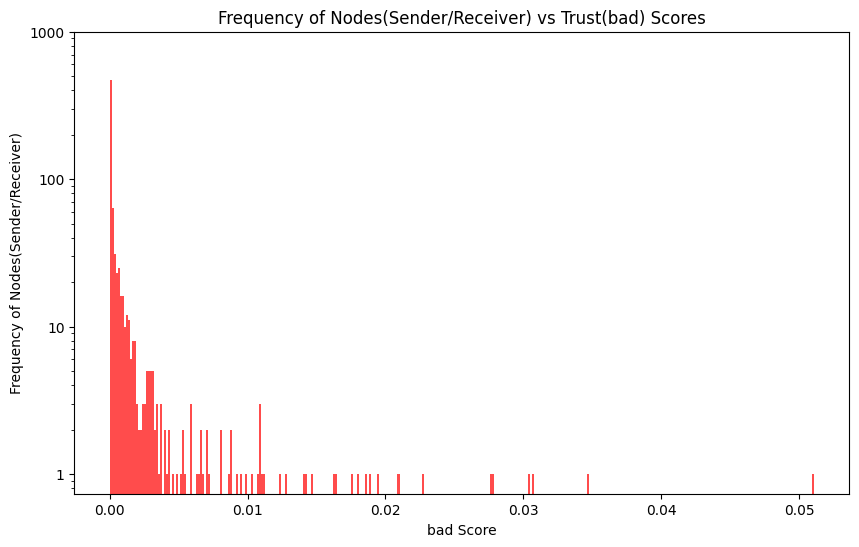

In [81]:
scores = []
with open("results.txt", "r") as file:
    for line in file:
        score = float(line.split("Score = ")[1])
        scores.append(score)

# Plot frequency of nodes vs scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=350, color='red', alpha=0.7)
plt.xlabel('bad Score')
plt.ylabel('Frequency of Nodes(Sender/Receiver)')
plt.title('Frequency of Nodes(Sender/Receiver) vs Trust(bad) Scores')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plt.savefig('score_distribution_frequency.png')
plt.show()